In [20]:
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the dataset and prepare data
df = pd.read_excel('Presentation - omics challenge Data.xlsx', index_col=0, header=1)
target = df['Label']
df = df.drop(['Label'], axis=1)
df_amino = df.iloc[:, 0:21]
df_prot = df.iloc[:, 21:]

In [21]:
# Scaling using MinMaxScaler
scaler = MinMaxScaler()
df_amino_scaled = pd.DataFrame(scaler.fit_transform(df_amino), columns=df_amino.columns, index=df.index)
df_prot_scaled = pd.DataFrame(scaler.fit_transform(df_prot), columns=df_prot.columns, index=df.index)

# Combine scaled data
df_combined = pd.concat([df_amino_scaled, df_prot_scaled], axis=1)

# Encode the labels to binary format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(target)  # 'Control' becomes 0, 'CRC' becomes 1

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_combined, y_encoded, stratify=y_encoded, random_state=42)

5-Fold Cross-Validation scores: [1.         0.5        0.75       0.66666667 0.66666667]
Mean CV score: 0.7166666666666666
Standard Deviation of CV scores: 0.16329931618554522


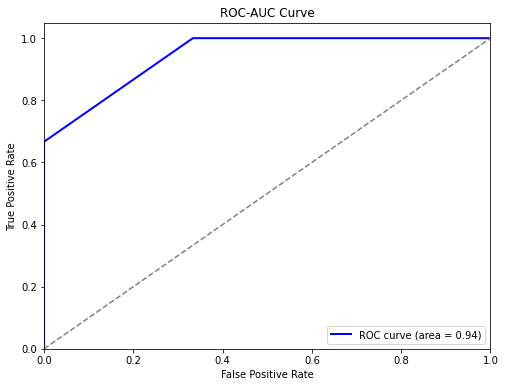

Best hyperparameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 8}
Best score: 0.8375


In [22]:
# Define the Random Forest model and GridSearchCV parameters
param_grid = {
    'bootstrap': [True],
    'max_depth': [2, 4, 8, 16],
    'min_samples_leaf': [2, 3],
    'n_estimators': [4, 8]
}

rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid=param_grid, cv=4, scoring='accuracy')
model_grid = grid.fit(X_train, y_train)

# k-Fold Cross-Validation
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_grid.best_estimator_, X_train, y_train, cv=kf, scoring='accuracy')

print(f'{k}-Fold Cross-Validation scores:', cv_scores)
print('Mean CV score:', cv_scores.mean())
print('Standard Deviation of CV scores:', cv_scores.std())

# ROC-AUC Curve (on the test set)
best_rf = model_grid.best_estimator_
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

print('Best hyperparameters:', model_grid.best_params_)
print('Best score:', model_grid.best_score_)

Accuracy: 0.67
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



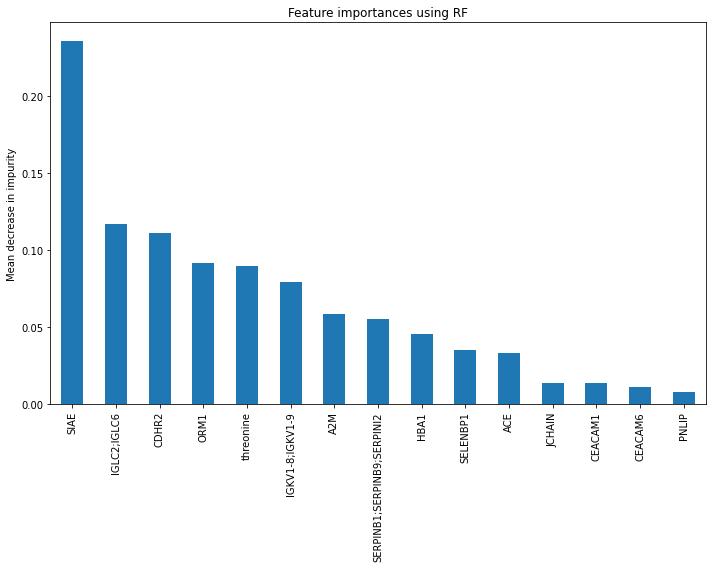

In [24]:
# Model evaluation on test set
rf_optimized = model_grid.best_estimator_
y_pred = rf_optimized.predict(X_test)

# Print accuracy and classification report
print('Accuracy: {:0.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

# Feature importances
forest_importances = pd.Series(rf_optimized.feature_importances_, index=df_combined.columns)
sorted_features = forest_importances.sort_values(ascending=False)

# Select number of features
n = 15
fig, ax = plt.subplots(figsize=(10, 8))
sorted_features[0:n].plot.bar(ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
